The point of this notebook is to try to group together the time buckets based on similar mean and standard deviation of the Lat/lon of the RTAs that occur in the bucket.
I use a clustering technique to see if the mean/stdev combinations can be grouped effectively

In [4]:
import pandas as pd
import numpy as np
import re
import datetime
import math
from sklearn.cluster import KMeans
import geopandas as gpd
import h3 # h3 bins from uber
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df

def create_temporal_features(df):
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    
    df["time_window"] = df["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df["datetime"].apply(lambda x: x.day)
    df["month"] = df["datetime"].apply(lambda x: dict_months.get(x.month))
    df["year"] = df["datetime"].apply(lambda x: x.year)
    df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
    return df

def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
    return df

In [57]:
# load data and apply feautre engineering, drop unnessecary columns
crash_df = create_crash_df(train_file = '../nairobi-capstone/Inputs/Train.csv')
crash_df = create_temporal_features(crash_df)
crash_df = assign_hex_bin(crash_df)
#crash_df = crash_df.drop(['uid','day','year','time_window','datetime'], axis=1)
crash_df = crash_df.drop(['uid','day','year','time_window','datetime','month'], axis=1)
# group by identified seasonal features, get aggregate values for these groups
crash_group = crash_df.groupby(['time_window_str', 'weekday'])
group_stats = crash_group.agg({'latitude': [np.mean, np.std],'longitude': [np.mean, np.std, 'count']})
# flatten out groupby object and rename columns
group_stats = group_stats.reset_index()
group_stats.columns = group_stats.columns.get_level_values(0)
group_stats.columns.values[[2,3,4,5,6]] = ['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std','RTA_count']
#group_stats.dropna(inplace=True)
group_stats

,time_window_str,weekday,latitude_mean,latitude_std,longitude_mean,longitude_std,RTA_count
0,00-03,0,-1.254350,0.115130,36.847357,0.085905,72
1,00-03,1,-1.281566,0.241591,36.893242,0.183313,37
2,00-03,2,-1.268346,0.199099,36.883045,0.142915,40
3,00-03,3,-1.237684,0.078702,36.877046,0.085493,46
4,00-03,4,-1.274551,0.066954,36.829331,0.077903,39
5,00-03,5,-1.289353,0.071129,36.885139,0.118845,28
6,00-03,6,-1.281676,0.084958,36.874088,0.079523,34
7,03-06,0,-1.283967,0.098701,36.839259,0.082168,61
8,03-06,1,-1.319208,0.307551,36.936040,0.222926,55
9,03-06,2,-1.285171,0.049175,36.838206,0.070660,69


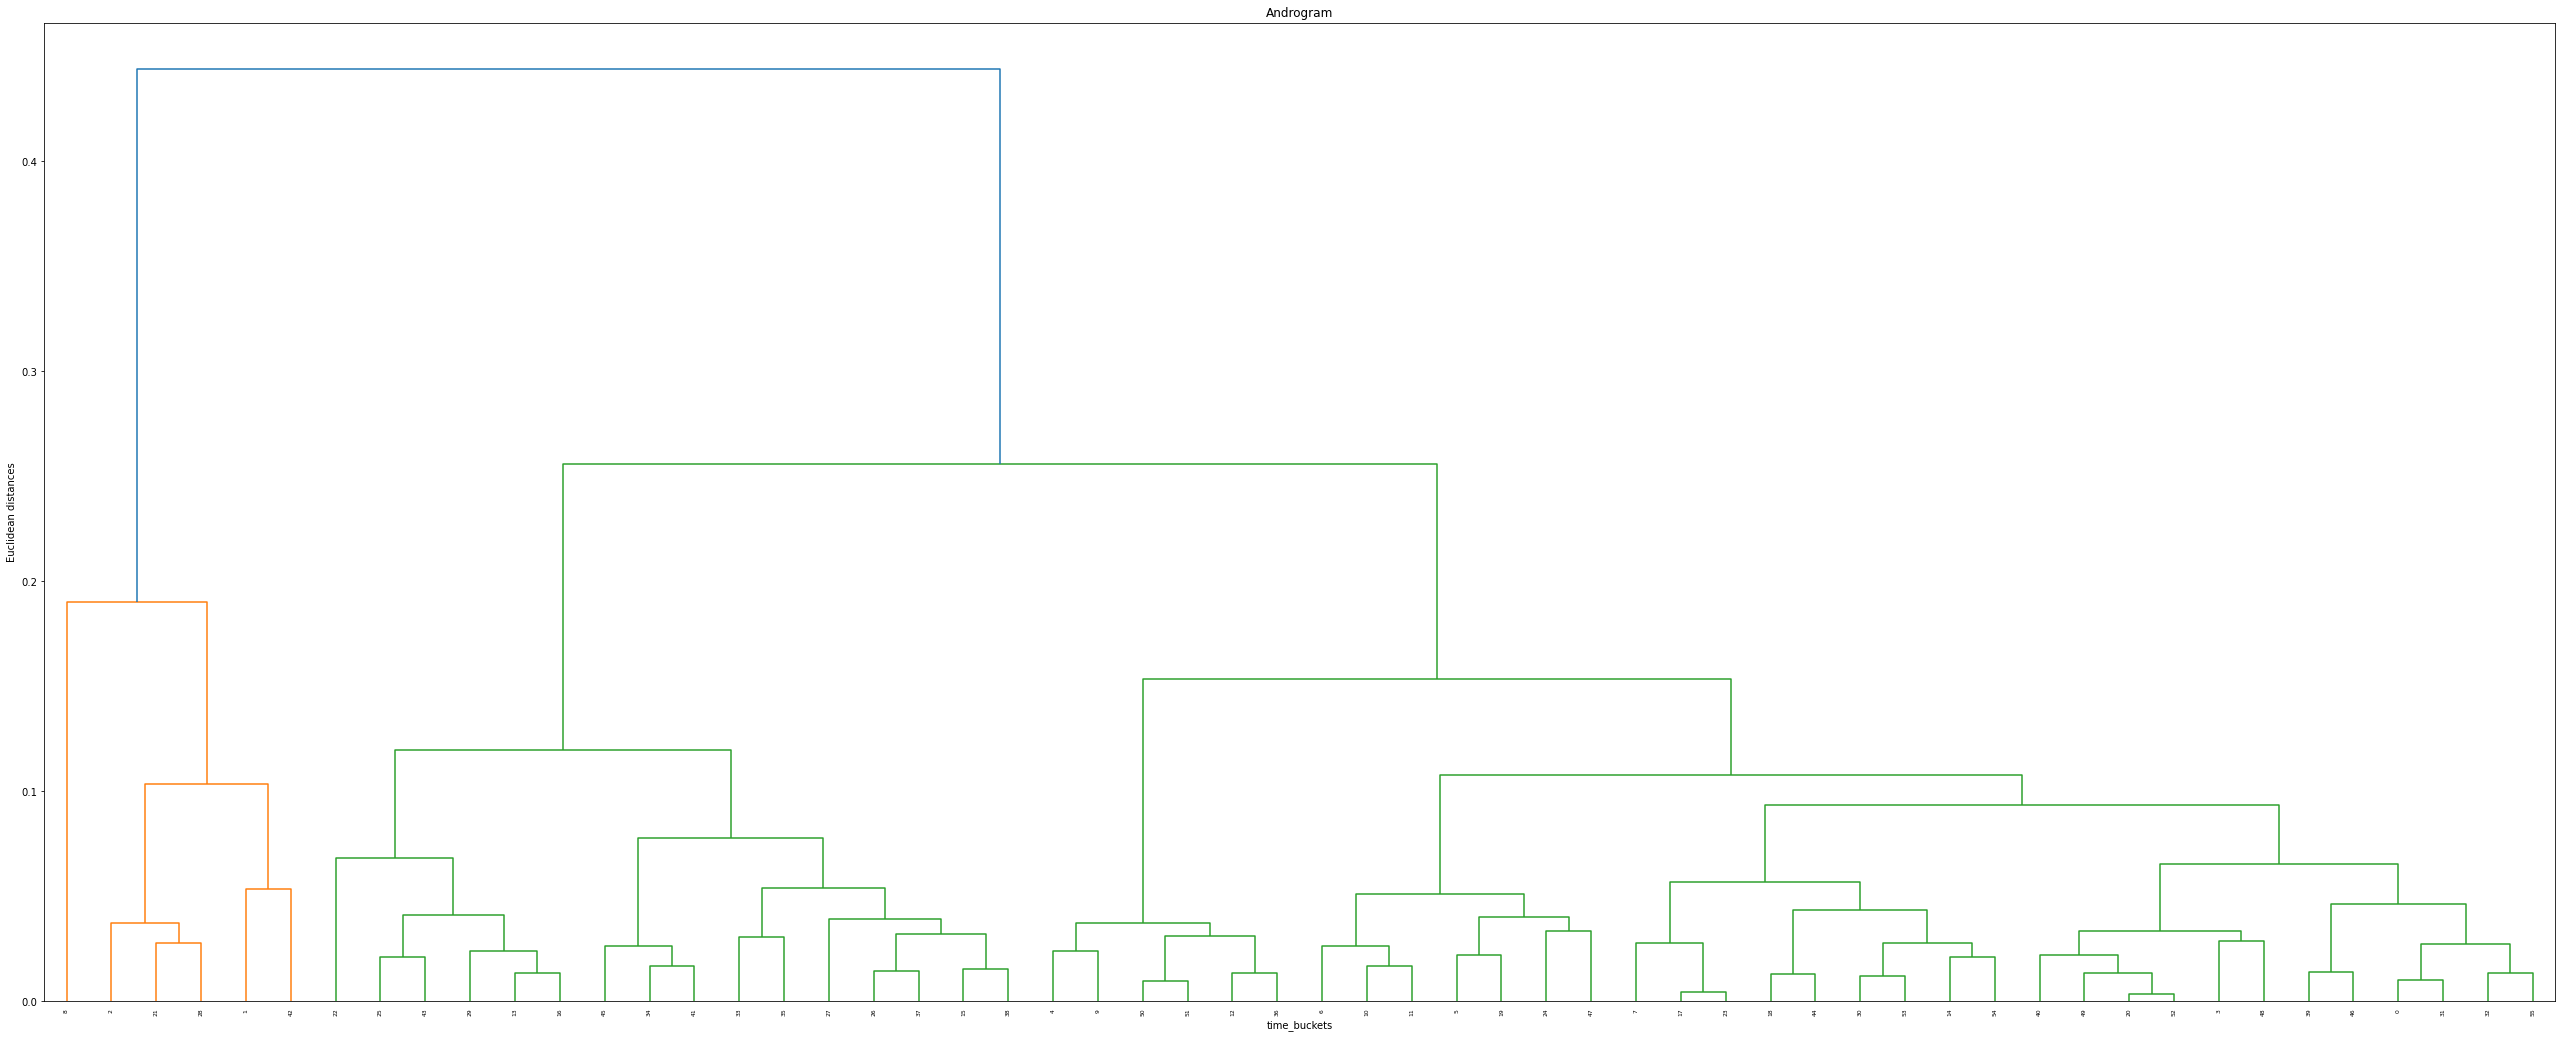

In [58]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(45,18))
plt.title('Androgram')
plt.xlabel('time_buckets')
plt.ylabel('Euclidean distances')
#plt.grid(True)
#dendrogram = sch.dendrogram(sch.linkage(crash_data_df[['latitude','longitude']], method = 'ward'))
dendrogram = sch.dendrogram(sch.linkage(group_stats[['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']], method = 'ward'))
plt.show()

### Based on the dendrogram, there should be 2 clusters of time buckets based on the mean and standard devation. 
the first cluster is very small relative to the second. Perhaps 3 clusters could then be taken as there is quite a lot of difference between the other two big groups.

Initialization 0
  Iteration 10	 time lapse 0.03813s	 ll change 0.00527
Initialization converged: True	 time lapse 0.04211s	 ll 10.92737


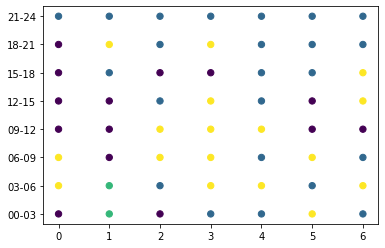

In [96]:
from sklearn.mixture import GaussianMixture
X = group_stats[['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']]
gmm = GaussianMixture(n_components=4, verbose=10, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)
labels = pd.DataFrame(labels,columns=['cluster'])
clustered_time_buckets = pd.concat([group_stats,labels],axis=1)
plt.scatter(clustered_time_buckets['weekday'], clustered_time_buckets['time_window_str'], c=clustered_time_buckets['cluster'], s=40, cmap='viridis');

In [99]:
# Number of time buckets in each cluster
display(clustered_time_buckets.groupby('cluster')['RTA_count'].count())
# Number of RTAs in each cluster
displclustered_time_buckets.groupby('cluster')['RTA_count'].sum()

cluster
0    1871
1    2100
2      92
3    2255
Name: RTA_count, dtype: int64